In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
kaipara = pd.read_csv('../../Data/soil data/AcrossAucklandRainfallStation/Kaipara_Data_15mins.csv', parse_dates=['Timestamp (UTC+12:00)'])
kaipara.head()

,Timestamp (UTC+12:00),Rain(mm),SoilTemp(c),SoilMoisture(%)
0,2014-07-08 00:30:00,0.0,13.4,39.218
1,2014-07-08 00:45:00,0.0,13.3,39.220
2,2014-07-08 01:00:00,0.0,13.3,39.220
3,2014-07-08 01:15:00,0.0,13.3,39.220
4,2014-07-08 01:30:00,0.0,13.3,39.221


Resample Data to 15 minutes interval

In [26]:
kaipara.set_index('Timestamp (UTC+12:00)', inplace=True)

resampled_df = kaipara.resample('H').agg({
    'Rain(mm)': 'sum',
    'SoilTemp(c)': 'mean',
    'SoilMoisture(%)': 'mean'
})

C:\Users\Ying\AppData\Local\Temp\ipykernel_4912\345378784.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_df = kaipara.resample('H').agg({


Cross-correlation

In [27]:
import numpy as np
from scipy.signal import correlate
import matplotlib.pyplot as plt

max_lag = 30

def cross_correlation(x, y, max_lag):
    """Calculate cross-correlation between two signals."""
    correlation = correlate(x, y, mode='full')
    lags = np.arange(-len(x) + 1, len(y))
    return lags, correlation

In [28]:
kaipara_daily = kaipara.resample('D').agg({'Rain(mm)': 'sum','SoilTemp(c)': 'mean','SoilMoisture(%)': 'mean'})

In [29]:
soil_moisture = kaipara_daily['SoilMoisture(%)'].values
rainfall = kaipara_daily['Rain(mm)'].values
soil_temp = kaipara_daily['SoilTemp(c)'].values

In [30]:
kaipara_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3717 entries, 2014-07-08 to 2024-09-09
Freq: D
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rain(mm)         3717 non-null   float64
 1   SoilTemp(c)      3424 non-null   float64
 2   SoilMoisture(%)  3424 non-null   float64
dtypes: float64(3)
memory usage: 116.2 KB


In [31]:
# Calculate 7-day rolling average for Rain(mm), SoilTemp(c), and SoilMoisture(%)
kaipara_daily['Rain_7d_avg'] = kaipara_daily['Rain(mm)'].rolling(window=7, min_periods=1).sum()
kaipara_daily['SoilTemp_7d_avg'] = kaipara_daily['SoilTemp(c)'].rolling(window=7, min_periods=1).mean()

# Calculate 30-day rolling average for the same columns
kaipara_daily['Rain_30d_avg'] = kaipara_daily['Rain(mm)'].rolling(window=30, min_periods=1).sum()
kaipara_daily['SoilTemp_30d_avg'] = kaipara_daily['SoilTemp(c)'].rolling(window=30, min_periods=1).mean()
# ararimu_daily['SoilMoisture_30d_avg'] = ararimu_daily['SoilMoisture(%)'].rolling(window=30, min_periods=1).mean()
kaipara_daily.head()


,Rain(mm),SoilTemp(c),SoilMoisture(%),Rain_7d_avg,SoilTemp_7d_avg,Rain_30d_avg,SoilTemp_30d_avg
Timestamp (UTC+12:00),,,,,,,
2014-07-08,1.89,12.659574,39.152202,1.89,12.659574,1.89,12.659574
2014-07-09,6.60,12.609375,39.322240,8.49,12.634475,8.49,12.634475
2014-07-10,7.54,13.390625,39.663281,16.03,12.886525,16.03,12.886525
2014-07-11,8.02,13.501042,39.415719,24.05,13.040154,24.05,13.040154
2014-07-12,49.05,13.558333,40.117708,73.10,13.143790,73.10,13.143790


In [32]:
rainfall_lags = [1, 3, 5, 7, 30,60]  
soil_temp_lags = [1, 3, 7, ] 


for i in rainfall_lags:
    kaipara_daily[f'Rainfall_lag_{i}'] = kaipara_daily['Rain(mm)'].shift(i)

for i in soil_temp_lags:
    kaipara_daily[f'SoilTemp_lag_{i}'] = kaipara_daily['SoilTemp(c)'].shift(i)

# Drop rows with NaN values in the lag features
kaipara_daily.dropna(inplace=True)

In [33]:
lag_size = 30
# Calculate cross-correlation for rainfall and soil temperature
lags_rain_temp, correlation_rain_temp = cross_correlation(rainfall, soil_temp, lag_size)
print("Cross-Correlation between Rainfall and Soil Temperature:")
print("Lags:", lags_rain_temp)
print("Correlation:", correlation_rain_temp)

Cross-Correlation between Rainfall and Soil Temperature:
Lags: [-3716 -3715 -3714 ...  3714  3715  3716]
Correlation: [nan nan nan ... nan nan nan]


c:\Users\Ying\.conda\envs\level8\lib\site-packages\scipy\signal\_signaltools.py:243: RuntimeWarning: Use of fft convolution on input with NAN or inf results in NAN or inf output. Consider using method='direct' instead.
  return convolve(in1, _reverse_and_conj(in2), mode, method)


In [34]:

# Calculate cross-correlation for rainfall and soil moisture
lags_rain_moist, correlation_rain_moist = cross_correlation(rainfall, soil_moisture, lag_size)
print("\nCross-Correlation between Rainfall and Soil Moisture:")
print("Lags:", lags_rain_moist)
print("Correlation:", correlation_rain_moist)


Cross-Correlation between Rainfall and Soil Moisture:
Lags: [-3716 -3715 -3714 ...  3714  3715  3716]
Correlation: [nan nan nan ... nan nan nan]


In [35]:
# Calculate cross-correlation for soil moisture and soil temperature
lags_moist_temp, correlation_moist_temp = cross_correlation(soil_moisture, soil_temp, lag_size)
print("\nCross-Correlation between Soil Moisture and Soil Temperature:")
print("Lags:", lags_moist_temp)
print("Correlation:", correlation_moist_temp)


Cross-Correlation between Soil Moisture and Soil Temperature:
Lags: [-3716 -3715 -3714 ...  3714  3715  3716]
Correlation: [nan nan nan ... nan nan nan]


<Axes: >

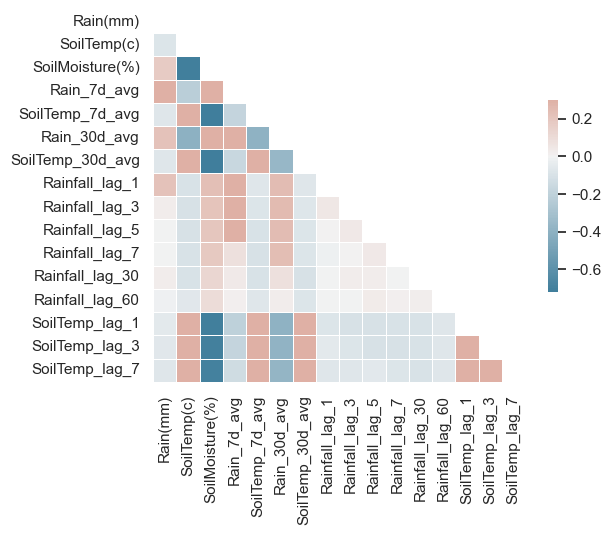

In [36]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")


# Compute the correlation matrix
corr = kaipara_daily.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Predictive Model

In [37]:
kaipara_daily.columns

Index(['Rain(mm)', 'SoilTemp(c)', 'SoilMoisture(%)', 'Rain_7d_avg',
       'SoilTemp_7d_avg', 'Rain_30d_avg', 'SoilTemp_30d_avg', 'Rainfall_lag_1',
       'Rainfall_lag_3', 'Rainfall_lag_5', 'Rainfall_lag_7', 'Rainfall_lag_30',
       'Rainfall_lag_60', 'SoilTemp_lag_1', 'SoilTemp_lag_3',
       'SoilTemp_lag_7'],
      dtype='object')

In [38]:

X = kaipara_daily.drop(columns=['SoilMoisture(%)'])

y = kaipara_daily[['SoilMoisture(%)']]

X.dropna(inplace=True)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (3343, 15)
y shape: (3343, 1)


In [39]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# Random Forest model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

c:\Users\Ying\.conda\envs\level8\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [41]:
len(X_train)

2674

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

def evaluate_model(predictions, y_test):
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, predictions)

    return mae, mse, rmse, r2

rf_mae, rf_mse, rf_rmse, rf_r2 = evaluate_model(rf_predictions, y_test)

print("\nRandom Forest Testing Set Metrics:")
print(f"MAE: {rf_mae}")
print(f"MSE: {rf_mse}")
print(f"RMSE: {rf_rmse}")
print(f"R2 Score: {rf_r2}")


Random Forest Testing Set Metrics:
MAE: 0.927983953578966
MSE: 1.7946547697647672
RMSE: 1.3396472557224783
R2 Score: 0.8816437297961944


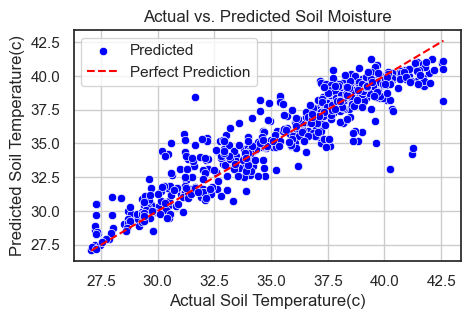

In [43]:
y_test_df = pd.DataFrame(y_test.reset_index(drop=True), columns=['SoilMoisture(%)'])
predictions_df = pd.DataFrame(rf_predictions, columns=['Predicted'])

results_df = pd.concat([y_test_df, predictions_df], axis=1)

plt.figure(figsize=(5, 3))
sns.scatterplot(x=results_df['SoilMoisture(%)'], y=results_df['Predicted'], color='blue', label='Predicted')
plt.plot([results_df['SoilMoisture(%)'].min(), results_df['SoilMoisture(%)'].max()], 
         [results_df['SoilMoisture(%)'].min(), results_df['SoilMoisture(%)'].max()], 
         color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs. Predicted Soil Moisture')
plt.xlabel('Actual Soil Temperature(c)')
plt.ylabel('Predicted Soil Temperature(c)')
plt.legend()
plt.grid()
plt.show()

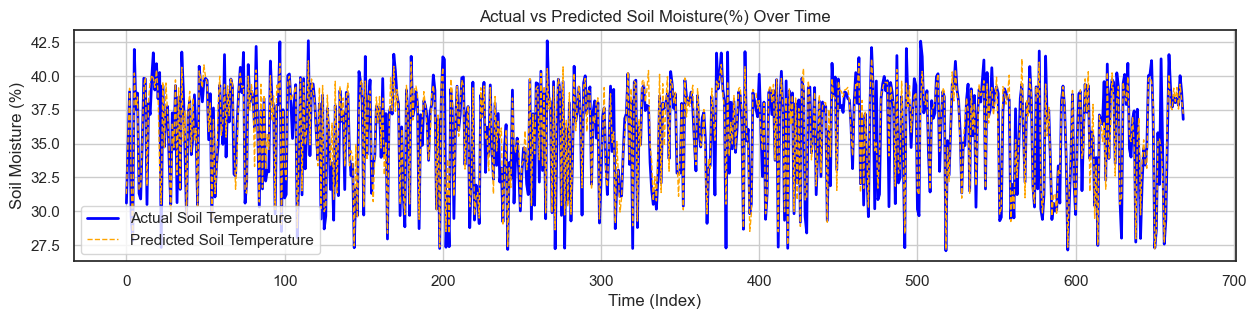

In [44]:
y_test_df = y_test.reset_index(drop=True)
predictions_df = pd.DataFrame(rf_predictions, columns=['Predicted'])
results_df = pd.concat([y_test_df, predictions_df], axis=1)

plt.figure(figsize=(15, 3))
plt.plot(results_df.index, results_df['SoilMoisture(%)'], label='Actual Soil Temperature', color='blue', linewidth=2)
plt.plot(results_df.index, results_df['Predicted'], label='Predicted Soil Temperature', color='orange',  linestyle='--', linewidth=1)

# Customize plot labels and legend
plt.title('Actual vs Predicted Soil Moisture(%) Over Time')
plt.xlabel('Time (Index)')
plt.ylabel('Soil Moisture (%)')
plt.legend()
plt.grid(True)
plt.show()

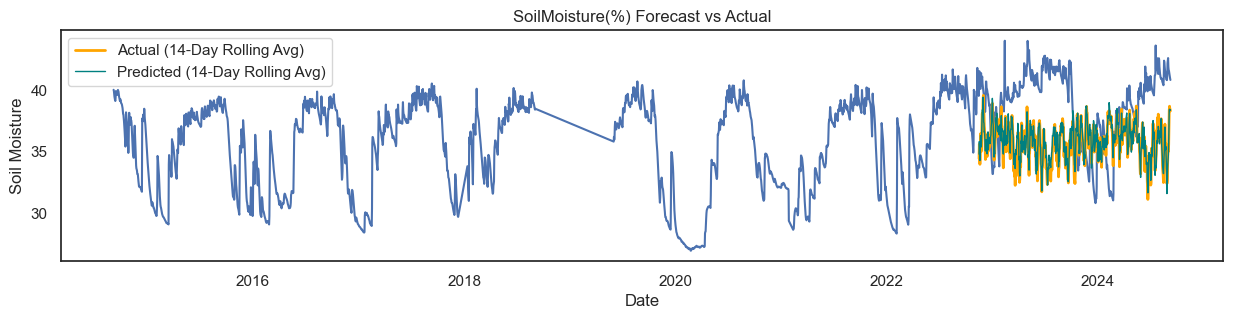

In [45]:
y_test_df = y_test.reset_index(drop=True)
predictions_df = pd.DataFrame(rf_predictions, columns=['Predicted'])
actual_rolling = results_df['SoilMoisture(%)'].rolling(window=7).mean()
predicted_rolling = results_df['Predicted'].rolling(window=7).mean()

results_df = pd.concat([y_test_df, predictions_df], axis=1)
results_df.index = kaipara_daily.index[-len(y_test):] 

plt.figure(figsize=(15, 3))
plt.plot(kaipara_daily['SoilMoisture(%)'])
plt.plot(results_df.index, actual_rolling, color='orange', label='Actual (14-Day Rolling Avg)', linewidth=2)
plt.plot(results_df.index, predicted_rolling, color='teal', label='Predicted (14-Day Rolling Avg)', linewidth=1)

plt.title('SoilMoisture(%) Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend()
plt.show()



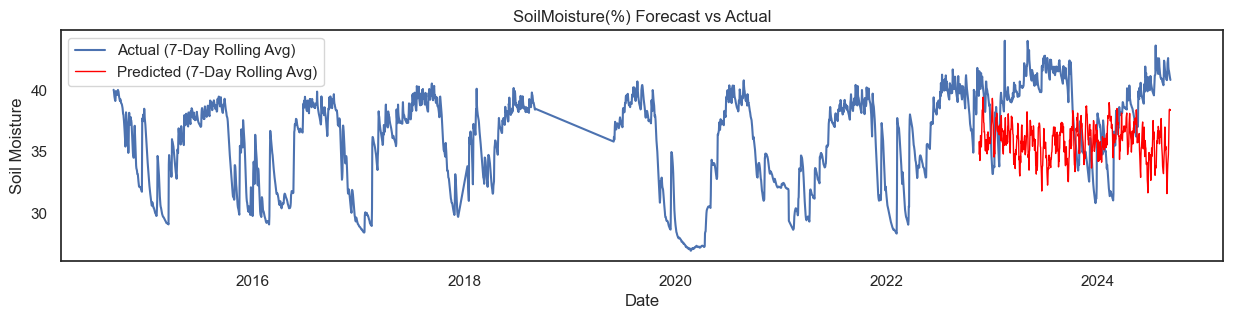

In [46]:
y_test_df = y_test.reset_index(drop=True)
predictions_df = pd.DataFrame(rf_predictions, columns=['Predicted'])
actual_rolling = kaipara_daily['SoilMoisture(%)'].rolling(window=7).mean()
predicted_rolling = results_df['Predicted'].rolling(window=7).mean()

results_df = pd.concat([y_test_df, predictions_df], axis=1)
results_df.index = kaipara_daily.index[-len(y_test):] 

plt.figure(figsize=(15, 3))
plt.plot(kaipara_daily['SoilMoisture(%)'], label='Actual (7-Day Rolling Avg)')
plt.plot(results_df.index, predicted_rolling, color='red', label='Predicted (7-Day Rolling Avg)', linewidth=1)

plt.title('SoilMoisture(%) Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend()
plt.show()

